<a href="https://colab.research.google.com/github/pragneshrana/Algo_Trial/blob/master/ML_DL_Finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  
- AI in Trading
    - Quantative Trading
    - Algorithmic trading
      - Breakout
      - Trend Following
      - Mean Reversion
      - Moving Average Crossover
      - Momentum Trading
      - Statistical Arbitrage
    - High Frequency Trading
    - Automated Trading
    
  

Goal:
  - Making buy and sell signal using technical indicators
  - Prediciting trend of stock price


### Fetching Data

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

symbol = 'ITC.NS'
start_date = '2020-01-01'
end_date = '2024-07-01'
yf.pdr_override() # <== that's all it takes :-)

stock_data = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [2]:
close_data = stock_data['Close']

### Generating 'Buy' and 'Sell' Signal
  - Here, Considered on daily data rather than generalized framework
  - No adjustments  are made to data (fot stock split, dividend and other actions)
  - Below work is illustrative purpose

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

def generate_signals(close_data, short_window=40, long_window=100):
    # Create a DataFrame to store signals
    signals = pd.DataFrame(index=close_data.index)
    signals['close'] = close_data
    signals['short_mavg'] = close_data.rolling(window=short_window, min_periods=1, center=False).mean()
    signals['long_mavg'] = close_data.rolling(window=long_window, min_periods=1, center=False).mean()

    # Create signals
    signals['signal'] = 0.0
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0)
    signals['positions'] = signals['signal'].diff()

    # Create a DataFrame to store trades
    trades = pd.DataFrame(index=signals.index)

    # Buy signal
    trades['buy_signal'] = np.where(signals['positions'] == 1, 1, 0)

    # Sell signal
    trades['sell_signal'] = np.where(signals['positions'] == -1, 1, 0)

    return signals, trades






In [4]:
def calculate_profit(signals, trades, initial_cash=10000):
    # Create a DataFrame for backtesting
    backtest = pd.DataFrame(index=signals.index)
    backtest['close'] = signals['close']
    backtest['position'] = signals['signal']
    backtest['buy_signal'] = trades['buy_signal']
    backtest['sell_signal'] = trades['sell_signal']

    # Calculate daily returns
    backtest['daily_returns'] = backtest['close'].pct_change()

    # Calculate daily cash value
    backtest['cash_value'] = (backtest['position'].shift(1) * backtest['daily_returns'] + 1).cumprod() * initial_cash

    return backtest


In [5]:
def plot_results(signals, backtest):
    # Plotting
    plt.figure(figsize=(14, 8))
    plt.plot(backtest['close'], label='Close Price', linewidth=2)
    plt.plot(signals['short_mavg'], label='Short MAvg', linestyle='--', alpha=0.7)
    plt.plot(signals['long_mavg'], label='Long MAvg', linestyle='--', alpha=0.7)
    plt.scatter(signals[signals['positions'] == 1].index, signals['short_mavg'][signals['positions'] == 1], marker='^', color='g', label='Buy Signal')
    plt.scatter(signals[signals['positions'] == -1].index, signals['short_mavg'][signals['positions'] == -1], marker='v', color='r', label='Sell Signal')
    plt.title('Buy/Sell Signals with Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

In [6]:
def calculate_trade_summary(backtest):
    trades = backtest[(backtest['buy_signal'] == 1) | (backtest['sell_signal'] == 1)]

    trade_summary = pd.DataFrame(index=trades.index)
    trade_summary['trade_type'] = np.where(trades['buy_signal'] == 1, 'Buy', 'Sell')
    trade_summary['trade_price'] = trades['close']
    trade_summary['trade_return'] = trade_summary['trade_price'].pct_change() * trade_summary['trade_type'].apply(lambda x: 1 if x == 'Buy' else -1)

    # Calculate profit and loss
    trade_summary['profit_loss'] = trade_summary['trade_return'].cumsum()

    # Calculate drawdowns
    trade_summary['drawdown'] = trade_summary['profit_loss'] - trade_summary['profit_loss'].cummax()
    trade_summary['drawup'] = trade_summary['profit_loss'] - trade_summary['profit_loss'].cummin()

    # Calculate maximum drawdown and minimum drawdown
    max_drawdown = trade_summary['drawdown'].min()
    min_drawdown = trade_summary['drawup'].min()

    return trade_summary, max_drawdown, min_drawdown



In [7]:
# Generate signals
signals, trades = generate_signals(close_data)

In [8]:
# Calculate profit
backtest = calculate_profit(signals, trades)


In [9]:
# Example usage
trade_summary, max_drawdown, min_drawdown = calculate_trade_summary(backtest)


In [10]:
# Display trade summary
display(trade_summary)

# Display maximum drawdown and minimum drawdown
print(f"Maximum Drawdown: {max_drawdown}")
print(f"Minimum Drawdown: {min_drawdown}")


,trade_type,trade_price,trade_return,profit_loss,drawdown,drawup
Date,,,,,,
2020-07-01,Buy,202.899994,NaN,NaN,NaN,NaN
2020-09-25,Sell,170.750000,0.158452,0.158452,0.000000,0.000000
2020-12-15,Buy,213.550003,0.250659,0.409111,0.000000,0.250659
2021-04-22,Sell,205.899994,0.035823,0.444934,0.000000,0.286482
2021-08-31,Buy,211.300003,0.026226,0.471161,0.000000,0.312708
2021-12-31,Sell,218.050003,-0.031945,0.439216,-0.031945,0.280763
2022-03-21,Buy,244.500000,0.121302,0.560518,0.000000,0.402066
2023-01-16,Sell,330.200012,-0.350511,0.210007,-0.350511,0.051554
2023-02-07,Buy,373.250000,0.130375,0.340382,-0.220136,0.181930


Maximum Drawdown: -0.405534368338343
Minimum Drawdown: 0.0


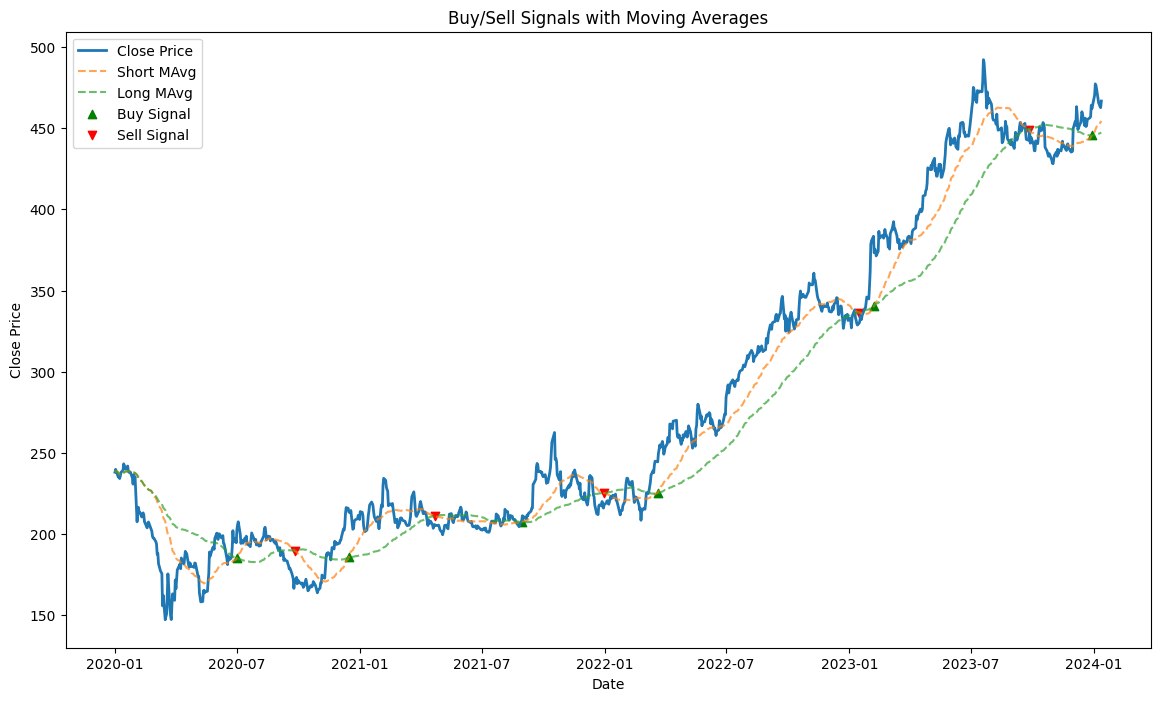

In [11]:
# Plot results
plot_results(signals, backtest)


## Deep learning  
- Predict trend of stock price


In [12]:
import pandas as pd
import numpy as np

def calculate_rsi(close_data, window=14):
    # Calculate daily price changes
    price_delta = close_data.diff(1)

    # Calculate gain (positive price changes) and loss (negative price changes)
    gain = price_delta.where(price_delta > 0, 0)
    loss = -price_delta.where(price_delta < 0, 0)

    # Calculate average gain and average loss over the specified window
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    # Calculate Relative Strength (RS) and Relative Strength Index (RSI)
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi


In [13]:

def calculate_moving_average(data, window=20):
    return data.rolling(window=window, min_periods=1).mean()


In [14]:
def calculate_exponential_moving_average(data, alpha=0.1):
    return data.ewm(alpha=alpha, adjust=False).mean()


In [15]:

def preprocess_data(data):

    data['rsi_14'] = calculate_rsi(data['Close'],window=14)
    data['rsi_5'] = calculate_rsi(data['Close'],window=5)
    data['mavg_10'] = calculate_moving_average(data['Close'],window=10)
    data['mavg_25'] = calculate_moving_average(data['Close'],window=25)
    data['mavg_50'] = calculate_moving_average(data['Close'],window=50)
    data['mavg_100'] = calculate_moving_average(data['Close'],window=100)
    data['mavg_200'] = calculate_moving_average(data['Close'],window=200)
    data['eavg_1'] = calculate_exponential_moving_average(data['Close'],alpha=0.1)
    data['eavg_4'] = calculate_exponential_moving_average(data['Close'],alpha=0.4)

    # Fill NaNs with the average of the next 5 values in each column
    columns_to_fill = ['rsi_14', 'rsi_5', 'mavg_10', 'mavg_25', 'mavg_50', 'mavg_100', 'mavg_200']

    for column in columns_to_fill:
        data[column] = data[column].fillna(data[column].shift(-5).rolling(window=5, min_periods=1).mean())
    data = data.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'])

    return data



In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [17]:

def build_model(input_shape, output_shape):
    model = Sequential()
    model.add(LSTM(15, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(8))
    model.add(Dropout(0.4))
    model.add(Dense(output_shape, activation='linear', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())  # Batch normalization layer
    model.compile(optimizer=Adam(), loss='mse')
    return model


In [18]:
def train_model(model, X_train, y_train, epochs=10):
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, verbose=1,batch_size=32, validation_split=0.2, callbacks=[early_stopping])


In [19]:

def predict_action(model, state):
    action = model.predict(state)
    return action



In [20]:
preprocessed_data = preprocess_data(stock_data)
preprocessed_data.columns

Index(['Adj Close', 'rsi_14', 'rsi_5', 'mavg_10', 'mavg_25', 'mavg_50',
       'mavg_100', 'mavg_200', 'eavg_1', 'eavg_4'],
      dtype='object')

In [21]:
preprocessed_data = preprocessed_data.reset_index(drop=True)

In [22]:
# Assuming 'your_data' is the DataFrame containing the preprocessed data
selected_columns = ['rsi_14', 'rsi_5', 'mavg_10', 'mavg_25', 'mavg_50', 'mavg_100', 'mavg_200', 'eavg_1', 'eavg_4']

# Create feature matrix X and target variable y
X = preprocessed_data[selected_columns].shift(-1).dropna()  # Shift to get the next day's values
y = preprocessed_data['Adj Close'].shift(-1).dropna()


In [23]:
# Reshape X for LSTM input (samples, time steps, features)
X = X.values.reshape((X.shape[0], 1, X.shape[1]))

# Build the LSTM model
input_shape = (X.shape[1], X.shape[2])
output_shape = 1  # Output shape for regression
model = build_model(input_shape, output_shape)

In [24]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [25]:
# # Standardize the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)


In [26]:
model = build_model(input_shape, output_shape)
train_model(model, X_train, y_train, epochs=100)


Epoch 1/100
20/20 [==============================] - 6s 71ms/step - loss: 84041.5547 - val_loss: 77120.3906
Epoch 2/100
20/20 [==============================] - 0s 7ms/step - loss: 84040.2031 - val_loss: 77125.7188
Epoch 3/100
20/20 [==============================] - 0s 8ms/step - loss: 84035.1953 - val_loss: 77101.1094
Epoch 4/100
20/20 [==============================] - 0s 10ms/step - loss: 84005.6797 - val_loss: 77088.0156
Epoch 5/100
20/20 [==============================] - 0s 9ms/step - loss: 83993.4062 - val_loss: 77067.5547
Epoch 6/100
20/20 [==============================] - 0s 7ms/step - loss: 83987.2422 - val_loss: 77046.2969
Epoch 7/100
20/20 [==============================] - 0s 9ms/step - loss: 83964.4766 - val_loss: 77071.7969
Epoch 8/100
20/20 [==============================] - 0s 7ms/step - loss: 83971.2734 - val_loss: 77023.9531
Epoch 9/100
20/20 [==============================] - 0s 7ms/step - loss: 83964.5234 - val_loss: 77019.6719
Epoch 10/100
20/20 [===============

In [27]:
loss = model.evaluate(X_test, y_test)
print(f'Testing loss: {loss}')

actions = predict_action(model, X_test)
# Model finetuning is required  further

7/7 [==============================] - 1s 2ms/step - loss: 82189.3047
Testing loss: 82189.3046875
7/7 [==============================] - 1s 2ms/step


## ARIMA & GARCH

In [28]:
!pip install arch
!pip install pmdarima


ARIMA and GARCH models, the prediction formula can be expressed as a product of the predicted conditional mean  from ARIMA and the predicted conditional volatility from GARCH.

$y_t = \hat{Y}_t \times \hat{\sigma}_t$


Let's break down each part:

$\textbf{ARIMA Prediction (\(\hat{Y}_t\)):}
Y_t = c + \phi_1 Y_{t-1} + \varepsilon_t
$​


After fitting the ARIMA model, you get the predicted conditional mean for each time point.

$
\textbf{GARCH Prediction (\(\hat{\sigma}_t\)):}
\sigma_t^2 = \omega + \alpha_1 \varepsilon_{t-1}^2 + \beta_1 \sigma_{t-1}^2
$

$
\textbf{Combined Prediction Formula:}
y_t = \hat{Y}_t \times \hat{\sigma}_t
$

The GARCH model is used to predict the conditional volatility  and you can obtain the predicted conditional standard deviation
This formula represents the combined prediction of the stock price, considering both the predicted mean and volatility. The idea is that the volatility predicted by the GARCH model adjusts the predicted mean from the ARIMA model, reflecting the uncertainty or variability in the stock price.



In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model


**Components of ARIMA:**

- ARIMA includes autoregressive, differencing, and moving average components.

- AutoRegressive (AR) Component (p): The AR part represents the correlation between the current observation and its past observations. The "p" parameter denotes the order of the AR component, which specifies how many lagged observations are considered.

- Integrated (I) Component (d): The I part involves differencing the time series to make it stationary. Stationarity is essential for time series models as it simplifies the process of modeling and forecasting. The "d" parameter represents the number of differencing required to make the series stationary.

- Moving Average (MA) Component (q): The MA part accounts for the correlation between the current observation and a residual error from a moving average model applied to lagged observations. The "q" parameter indicates the order of the MA component, specifying how many lagged residuals are considered.
The notation for an ARIMA model is ARIMA(p, d, q), where:

- p is the order of the autoregressive component.
- d is the degree of differencing.
- q is the order of the moving average component.

In [30]:
# Step 1: Fetch Historical Stock Price Data
stock_symbol = "ITC.NS"
start_date = "2022-01-01"
end_date = "2022-12-31"
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
closing_prices = stock_data['Close']


[*********************100%%**********************]  1 of 1 completed


In [31]:
# Step 2: ARIMA Model for Price Prediction
arima_model = ARIMA(closing_prices, order=(5, 1, 0))  # Adjust order as needed
arima_results = arima_model.fit()
forecast_horizon = 10
arima_forecast = arima_results.get_forecast(steps=forecast_horizon).predicted_mean


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

In [32]:
# Step 3: GARCH Model for Volatility Prediction
returns = closing_prices.pct_change().dropna()
garch_model = arch_model(returns, vol='Garch', p=1, q=1)
garch_results = garch_model.fit()
garch_forecast = garch_results.forecast(horizon=forecast_horizon).variance.iloc[-1, :]



Iteration:      1,   Func. Count:      6,   Neg. LLF: 83704585.54234211
Iteration:      2,   Func. Count:     17,   Neg. LLF: 937.7280497796388
Optimization terminated successfully    (Exit mode 0)
            Current function value: -714.9568587223984
            Iterations: 2
            Function evaluations: 23
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001821. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [34]:
# Step 4: Combine ARIMA Forecast with GARCH Volatility
volatility_forecast = np.sqrt(garch_forecast.cumsum())

# Make sure the indices are aligned and have a datetime format
combined_forecast = np.array(arima_forecast) + np.sqrt(garch_forecast.cumsum())

# Ensure forecast_horizon matches the number of forecasted periods
forecast_horizon = 10

# Make sure the indices are aligned and have a datetime format
combined_forecast.index = pd.date_range(start=closing_prices.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon, freq=closing_prices.index.freq)

# Convert combined forecast to datetime index
combined_forecast = pd.Series(combined_forecast.values, index=combined_forecast.index)



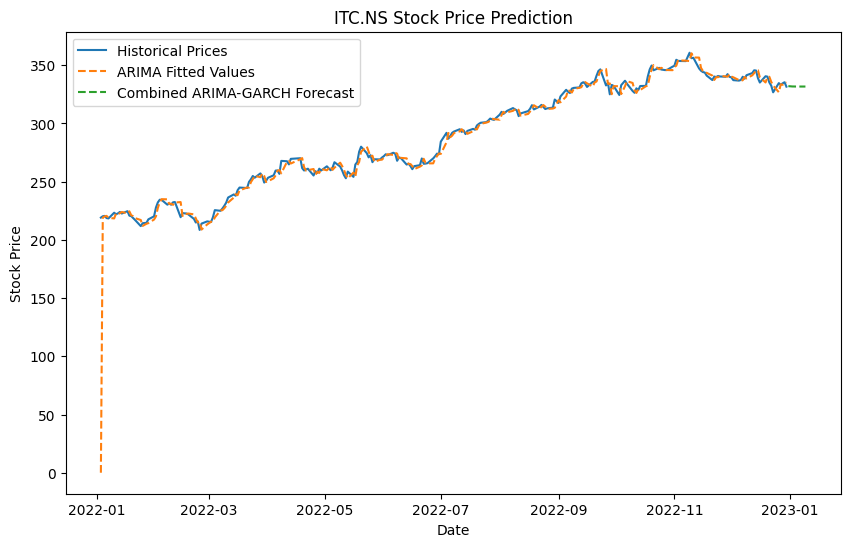

In [35]:
 # Plotting
plt.figure(figsize=(10, 6))
plt.plot(closing_prices, label='Historical Prices')
plt.plot(arima_results.fittedvalues, label='ARIMA Fitted Values', linestyle='--')
plt.plot(combined_forecast.index, combined_forecast, label='Combined ARIMA-GARCH Forecast', linestyle='--')
plt.title(f'{stock_symbol} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
